In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
file_dir = '/Users/fanxinwei/Desktop/code/train_data/uob_mini_project'
stock_file = file_dir + '/total_lob_30.csv'
df = pd.read_csv(stock_file)
df.head(10)

,date,time_window,max_bid,min_ask,bid_cumulative_depth,ask_cumulative_depth,avg_price,avg_price_change,bid_level_diff,ask_level_diff,bid_ask_depth_diff,next_avg_price_change,m_plus,l_t,label
0,2025-01-02,0.0,261.368421,282.421053,32.917293,18.669173,271.894737,NaN,-0.038715,0.038715,0.276199,-0.036612,263.756058,-0.029933,2
1,2025-01-02,30.0,259.367188,264.513021,19.747396,17.007812,261.940104,-0.036612,-0.009823,0.009823,0.074536,-0.004298,264.015979,0.007925,1
2,2025-01-02,60.0,258.338369,263.290030,22.129909,14.510574,260.814199,-0.004298,-0.009493,0.009493,0.207949,-0.002246,264.298728,0.013360,1
3,2025-01-02,90.0,258.089189,262.367568,18.494595,13.351351,260.228378,-0.002246,-0.008220,0.008220,0.161504,0.026154,264.545070,0.016588,1
4,2025-01-02,120.0,264.768571,269.300000,34.788571,12.662857,267.034286,0.026154,-0.008485,0.008485,0.466281,-0.013100,264.429008,-0.009756,2
5,2025-01-02,150.0,261.136490,265.935933,17.799443,12.632312,263.536212,-0.013100,-0.009106,0.009106,0.169794,0.004953,264.437640,0.003421,1
6,2025-01-02,180.0,262.738462,266.944615,27.283077,16.243077,264.841538,0.004953,-0.007941,0.007941,0.253641,0.000486,264.215651,-0.002363,2
7,2025-01-02,210.0,262.762712,267.177966,26.974576,14.618644,264.970339,0.000486,-0.008332,0.008332,0.297066,0.001173,263.784293,-0.004476,2
8,2025-01-02,240.0,262.631300,267.931034,22.445623,16.063660,265.281167,0.001173,-0.009989,0.009989,0.165725,0.003319,263.437484,-0.006950,2
9,2025-01-02,270.0,263.530997,268.792453,23.245283,15.215633,266.161725,0.003319,-0.009884,0.009884,0.208774,-0.009611,262.894930,-0.012274,2


In [4]:
df.shape

(6120, 3)

In [5]:
from pandas import Timedelta

# trade time start from 08:00:00
#start_date = pd.to_datetime('2025-01-02 08:00:00')
#df['actual_datetime'] = start_date + pd.to_timedelta(df['time_window'], unit='s')
#df.set_index('actual_datetime', inplace=True)

# 解析日期
df['date'] = pd.to_datetime(df['date'])
# 将时间窗口转换为timedelta（时间窗口以秒为单位），并设置每天的起始时间为8:00
df['datetime'] = df['date'] + pd.to_timedelta('8 hours') + pd.to_timedelta(df['time_window'], unit='s')
# 设置新的日期时间为索引
df.set_index('datetime', inplace=True)

price = df['avg_price']
price.head(10)

datetime
2025-01-02 08:00:00    271.894737
2025-01-02 08:00:30    261.940104
2025-01-02 08:01:00    260.814199
2025-01-02 08:01:30    260.228378
2025-01-02 08:02:00    267.034286
2025-01-02 08:02:30    263.536212
2025-01-02 08:03:00    264.841538
2025-01-02 08:03:30    264.970339
2025-01-02 08:04:00    265.281167
2025-01-02 08:04:30    266.161725
Name: avg_price, dtype: float64

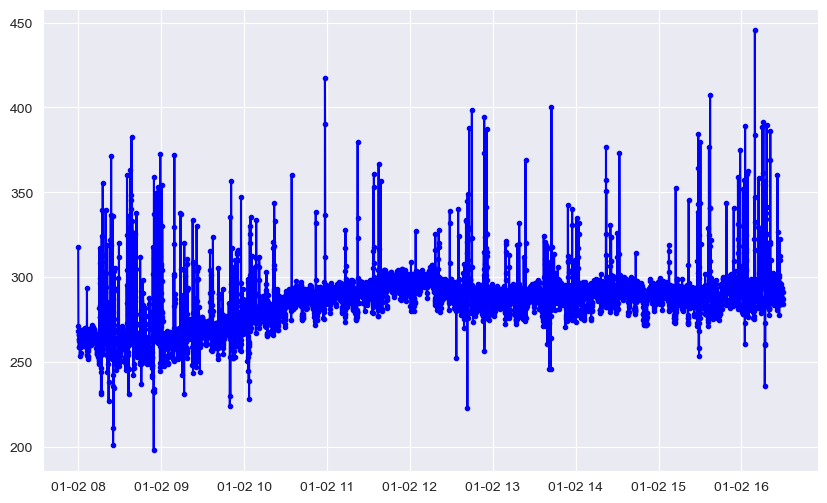

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(price, marker='.', linestyle='-', color='b')
plt.grid(True)

In [19]:
train_data = price[:-10]
test_data = price[-10:]
train_data_diff = train_data.diff(1)
train_data_diff = train_data_diff.dropna()


In [7]:
from statsmodels.tsa.stattools import adfuller
# ADF test (ADF(Augmented Dickey-Fuller) 强迪基-福勒检验)
def ADFtest(timeseries):
    # 执行Augmented Dickey-Fuller测试
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
ADFtest(train_data_diff)

Results of Augmented Dickey-Fuller Test:
Test Statistic                    -63.565172
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    127326.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


In [9]:
# cross validation
## using auto_arima to find the best ARIMA model
import pmdarima as pm
## 自动寻找最佳ARIMA模型

### remember to check y is base on with training data: train_avg ? or train_wavg?
auto_model = pm.auto_arima( train_data, start_p=0, start_q=0,
                            test='adf',
                            max_p=10, max_q=10,
                            seasonal=False,   ## if seasonal=True, need to add "start_P = " and "D="
                            # although "False" is been choosen, must set the "m="( but "m=" does't work)
                            suppress_warnings= 'True',
                            information_criterion= 'aic', ## using aic to choose the best model
                            error_action='ignore',
                            stepwise= False,    ## “True”(default) may cannot find the best way, but "False" will waste more time.
                            trace= True   ## print the detail of the searching process
                            )
auto_model.fit

print(auto_model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=85214.296, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=77319.036, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=71060.439, Time=0.58 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=66576.485, Time=0.95 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=63489.344, Time=1.03 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=2.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48225.906, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=47443.770, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=47374.542, Time=0.38 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=47357.338, Time=1.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47366.992, Time=0.90 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=47379.527, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=47346.507, Time=1.20 sec
 ARIMA(3,0,0)

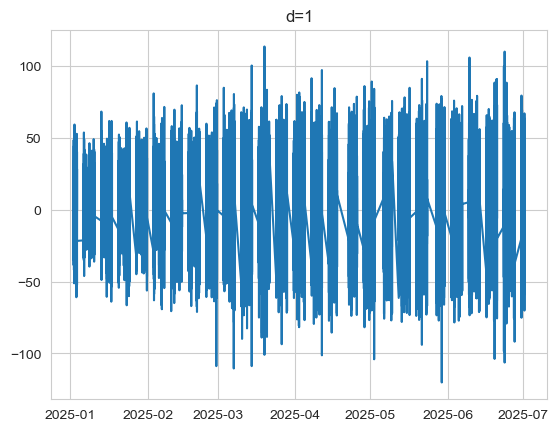

In [8]:
plt.figure()
plt.plot(train_data_diff)
plt.title('d=1')
plt.show()

/var/folders/90/3xy67qxj76v0lkc50q__s4t80000gn/T/ipykernel_89218/2485130713.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


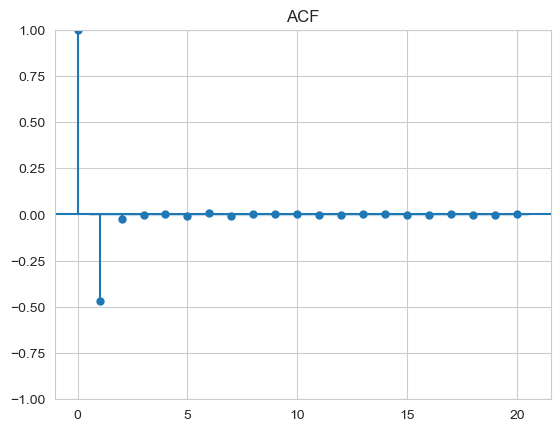

In [9]:
acf = plot_acf(train_data_diff, lags=20)
plt.title("ACF")
acf.show()

/var/folders/90/3xy67qxj76v0lkc50q__s4t80000gn/T/ipykernel_89218/4173882508.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pacf.show()


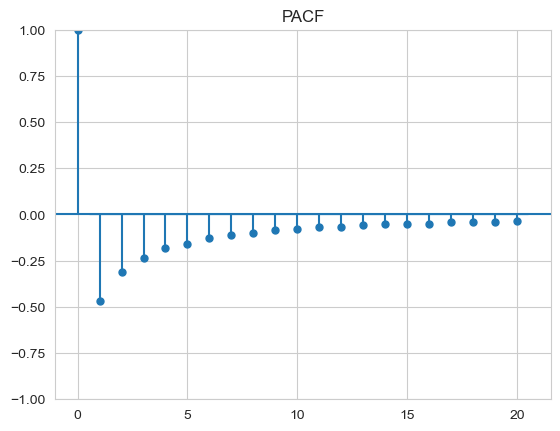

In [10]:
pacf = plot_pacf(train_data_diff, lags=20)
plt.title("PACF")
pacf.show()

In [20]:
model = ARIMA(train_data, order=(2, 1, 10))
results = model.fit()

/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
forecast = results.forecast(steps=10)

/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
forecast_df = pd.DataFrame(forecast.values, index=test_data.index)

In [23]:
forecast_df

,0
datetime,
2025-07-01 16:25:00,135.246817
2025-07-01 16:25:30,134.779445
2025-07-01 16:26:00,134.324060
2025-07-01 16:26:30,134.358190
2025-07-01 16:27:00,134.530592
2025-07-01 16:27:30,134.470342
2025-07-01 16:28:00,134.172026
2025-07-01 16:28:30,134.003099
2025-07-01 16:29:00,134.117253


In [24]:
test_data

datetime
2025-07-01 16:25:00    131.147493
2025-07-01 16:25:30    137.614887
2025-07-01 16:26:00    128.126959
2025-07-01 16:26:30    136.300604
2025-07-01 16:27:00    133.552189
2025-07-01 16:27:30    148.373476
2025-07-01 16:28:00    132.113402
2025-07-01 16:28:30    136.659164
2025-07-01 16:29:00    152.277985
2025-07-01 16:29:30    131.150470
Name: avg_price, dtype: float64

In [25]:
differences = forecast_df[0] - test_data
differences

datetime
2025-07-01 16:25:00     4.099324
2025-07-01 16:25:30    -2.835441
2025-07-01 16:26:00     6.197101
2025-07-01 16:26:30    -1.942415
2025-07-01 16:27:00     0.978403
2025-07-01 16:27:30   -13.903134
2025-07-01 16:28:00     2.058624
2025-07-01 16:28:30    -2.656065
2025-07-01 16:29:00   -18.160733
2025-07-01 16:29:30     2.943795
dtype: float64

In [26]:
total_difference = differences.abs().sum()
total_difference

55.77503491510336

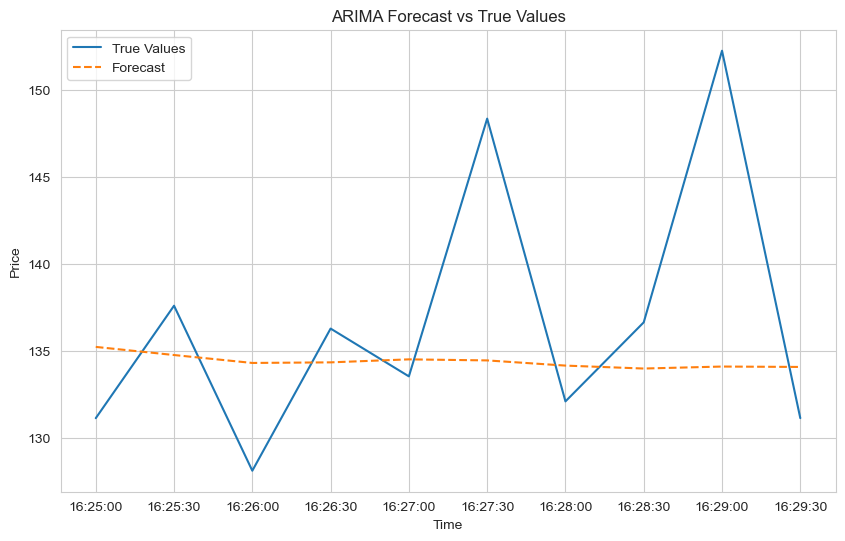

In [27]:
plt.figure(figsize=(10, 6))
# plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='True Values')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ARIMA Forecast vs True Values')
plt.legend()
plt.show()